<a href="https://colab.research.google.com/github/AndreyDyachkov/Data_analytics_with_Python_2/blob/main/AB-tests_health_insurance_products/AB_test_Excess_in_health_insurance_product.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A/B test of a product modification. Estimation of the effect of the deductible on a health insurance product

### Goal

Estimate the impact of excess on average loss per customer per month and frequency for a health insurance product. In this case, frequency is the number of policyholders who visited a clinic in a month divided by the number of all policyholders. The excess was added in order to decrease loss, therefore  the average loss per customer per month and frequency should be decreased as well.

### Tasks

1. Find the clients (legal entities) which were added deductible at the renewal of their contracts.
2. Estimates the change of the average loss per policyholder per month before and after implementing the deductible.
3. Compare the average loss per unique policyholder before the deductible and after implementing it.
4. Compare the percentage of policyholders who visited healthcare facilities before the deductible and after it.
5. Calculate statistical significance of the differences.

Data source: data on the amount of payment for each policy per month for each clinic, including those where the deductible was working.



### Results

10% excess significantly decreased both indicators. The number of policyholders visiting health facilities dropped by 53% after adding an excess to the product. The difference is statistically significant (p<0.01). The average loss per policyholder dropped by 27% and the difference is statistically significant (p < 0.05).

### Imports and data processing

In [ ]:
import pandas as pd
import numpy as np

from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Data_analytics_with_Python_2/AB-tests_health_insurance_products/data/deductible_data.xlsx')
df.head()

,HOLDING,MedOrg.Company_name,MedOrg._entity,CODE,BEGDATE,CloseEndDate,POLCODE,type,Loss,YearMonthnumber
0,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0037,fact,630,2017/02
1,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0050,fact,630,2017/02
2,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0053,fact,1260,2017/02
3,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0066,fact,630,2017/02
4,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0127,fact,630,2017/02


In [ ]:
df.columns = ['group','company','entity','contract_id','start_date','end_date','policy_id','type','loss','year_month']
df.head()

,group,company,entity,contract_id,start_date,end_date,policy_id,type,loss,year_month
0,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0037,fact,630,2017/02
1,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0050,fact,630,2017/02
2,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0053,fact,1260,2017/02
3,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0066,fact,630,2017/02
4,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0127,fact,630,2017/02


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1078 entries, 0 to 1077
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   group        701 non-null    object        
 1   company      1078 non-null   object        
 2   entity       1078 non-null   object        
 3   contract_id  1078 non-null   int64         
 4   start_date   1078 non-null   datetime64[ns]
 5   end_date     1078 non-null   datetime64[ns]
 6   policy_id    1078 non-null   object        
 7   type         1078 non-null   object        
 8   loss         1078 non-null   int64         
 9   year_month   1078 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(6)
memory usage: 84.3+ KB


### EDA

In [ ]:
df['loss'].describe()

count     1078.000000
mean      7640.271800
std       7023.229052
min        490.000000
25%       2500.000000
50%       5480.000000
75%      10394.500000
max      51550.000000
Name: loss, dtype: float64

Presumably, it is a right-skewed distribution.

Let's draw a histogram.

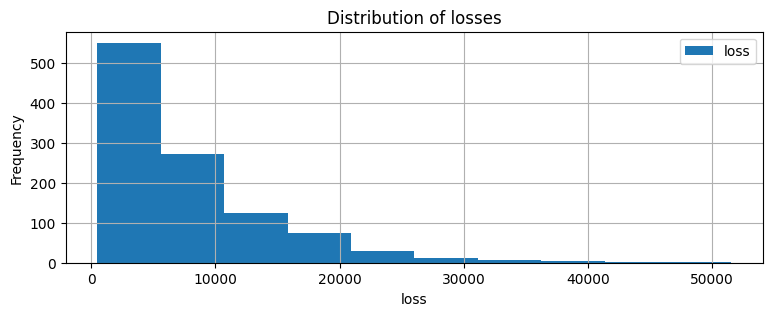

In [ ]:
df.plot(kind='hist', y='loss', bins=10, grid=True, figsize=(9,3), title='Distribution of losses')
plt.xlabel('loss')
plt.ylabel('Frequency')
plt.show()

and a boxplot to show changes by year

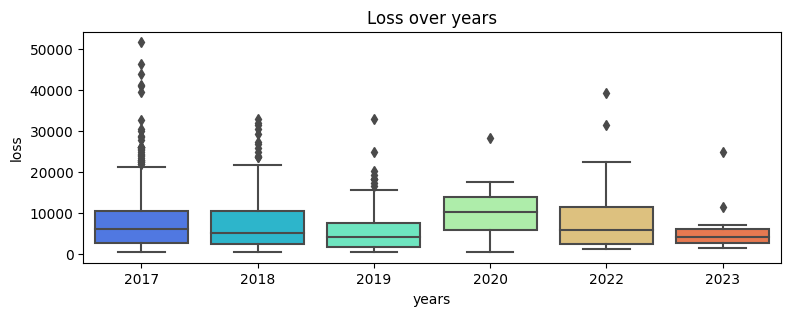

In [ ]:
plt.figure(figsize=(9,3))
sns.boxplot(x=df['year_month'].str[:4], y='loss', data=df.sort_values(by='year_month'), palette='rainbow').set(
    xlabel='years',
    ylabel='loss')
plt.title('Loss over years')
plt.show()

We can see a lognormal distribution on the histogram, typical for losses. The median changes quite a lot over the years. There are some outliers, which we will remove.

In [ ]:
fixed_df = df[(df['loss'] < 35000)]

Let's convert a lognormal distribution to normal in order to apply statistical tests afterwards

In [ ]:
fixed_df['ln_loss'] = np.log(fixed_df['loss'])
fixed_df.head()

<ipython-input-11-6d33006d5698>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fixed_df['ln_loss'] = np.log(fixed_df['loss'])


,group,company,entity,contract_id,start_date,end_date,policy_id,type,loss,year_month,ln_loss
0,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0037,fact,630,2017/02,6.445720
1,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0050,fact,630,2017/02,6.445720
2,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0053,fact,1260,2017/02,7.138867
3,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0066,fact,630,2017/02,6.445720
4,NaN,company_17,entity,1483029,2016-08-01,2017-07-31,047-2016-G/0127,fact,630,2017/02,6.445720


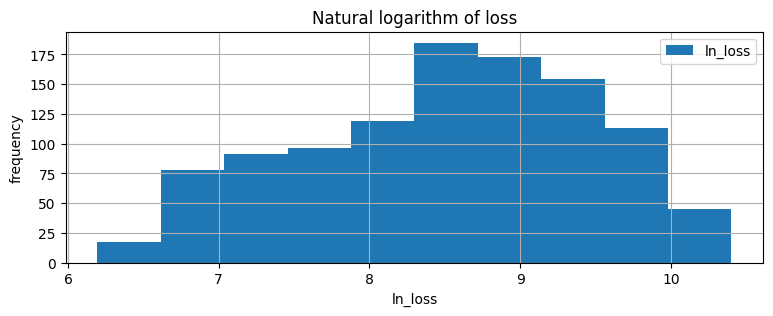

In [ ]:
fixed_df.plot(kind='hist', y='ln_loss', bins=10, grid=True, figsize=(9,3), title='Natural logarithm of loss')
plt.xlabel('ln_loss')
plt.ylabel('frequency')
plt.show()

We've got a normal distribution (more or less)

### Find right clients to assess

Get companies having an excess in their contracts

In [ ]:
target_companies = fixed_df[fixed_df['type']=='deductible']['company'].unique()
target_companies

array(['company_6', 'company_21'], dtype=object)

In [ ]:
df_target_companies = fixed_df[fixed_df['company'].isin(target_companies)]
df_target_companies.head()

,group,company,entity,contract_id,start_date,end_date,policy_id,type,loss,year_month,ln_loss
47,NaN,company_6,entity,1482204,2016-08-01,2017-07-31,045-2016-G/0003,fact,2890,2017/05,7.969012
120,NaN,company_6,entity,1482204,2016-08-01,2017-07-31,045-2016-G/0003,fact,4950,2017/06,8.507143
177,NaN,company_6,entity,1482204,2016-08-01,2017-07-31,045-2016-G/0003,fact,6830,2017/07,8.829080
301,group_2,company_21,entity,5787757,2017-08-01,2018-07-31,1-16-02-0044-GVMI/7,fact,4440,2017/09,8.398410
349,group_2,company_21,entity,5787757,2017-08-01,2018-07-31,1-16-02-0044-GVMI/7,fact,7700,2017/10,8.948976


In [ ]:
df_target_companies.pivot_table(index='year_month', columns='type', values='loss', aggfunc=['sum','count'])

sum                count      
type       deductible      fact deductible  fact
year_month                                      
2017/05           NaN    2890.0        NaN   1.0
2017/06           NaN    4950.0        NaN   1.0
2017/07           NaN    6830.0        NaN   1.0
2017/09           NaN    4440.0        NaN   1.0
2017/10           NaN    7700.0        NaN   1.0
2017/11           NaN    7050.0        NaN   1.0
2017/12           NaN    3420.0        NaN   1.0
2018/01           NaN    1040.0        NaN   1.0
2018/03           NaN   99760.0        NaN  11.0
2018/04           NaN   83120.0        NaN  16.0
2018/05           NaN   99740.0        NaN  16.0
2018/06           NaN   76270.0        NaN  11.0
2018/07           NaN  121490.0        NaN  16.0
2018/08        8086.0       NaN        2.0   NaN
2018/09       35650.0       NaN        4.0   NaN
2018/10       30575.0       NaN        6.0   NaN
2018/11       28427.0       NaN        6.0   NaN
2018/12       28165.0       NaN        6.0   NaN
2019/01       10134.0       NaN        2.0   NaN
2019/02       16840.0       NaN        5.0   NaN
2019/03       34520.0       NaN        7.0   NaN
2019/04       15013.0       NaN        6.0   NaN
2019/05       15217.0       NaN        3.0   NaN
2019/06       32287.0       NaN        5.0   NaN
2019/07       37541.0       NaN        6.0   NaN

Let's combine company 6, company 21  (in fact these are 2 contracts of 1 company). Period to test: 03-07.2018 and 03-07.2019 to avoid a seasonal factor

### Average loss per policyholder before and during the deductible period

Define both periods

In [ ]:
control_period = ['2018/03','2018/04','2018/05','2018/06','2018/07']
test_period = ['2019/03','2019/04','2019/05','2019/06','2019/07']

Make control (before an excess) and test (with an excess) groups

In [ ]:
control_sample = df_target_companies[df_target_companies['year_month'].isin(control_period)][['loss','ln_loss']]
control_sample

,loss,ln_loss
629,3210,8.074026
630,2590,7.859413
631,6650,8.802372
632,8130,9.003316
633,31970,10.372553
...,...,...
771,6340,8.754634
772,7870,8.970813
773,20650,9.935471
774,4080,8.313852


In [ ]:
test_sample = df_target_companies[df_target_companies['year_month'].isin(test_period)][['loss','ln_loss']]
test_sample

,loss,ln_loss
894,1012,6.919684
895,10396,9.249176
896,5875,8.678461
897,884,6.784457
898,884,6.784457
899,12477,9.431642
900,2992,8.003697
910,3834,8.251664
911,884,6.784457
912,3766,8.233769


Let's look at the histograms of those groups

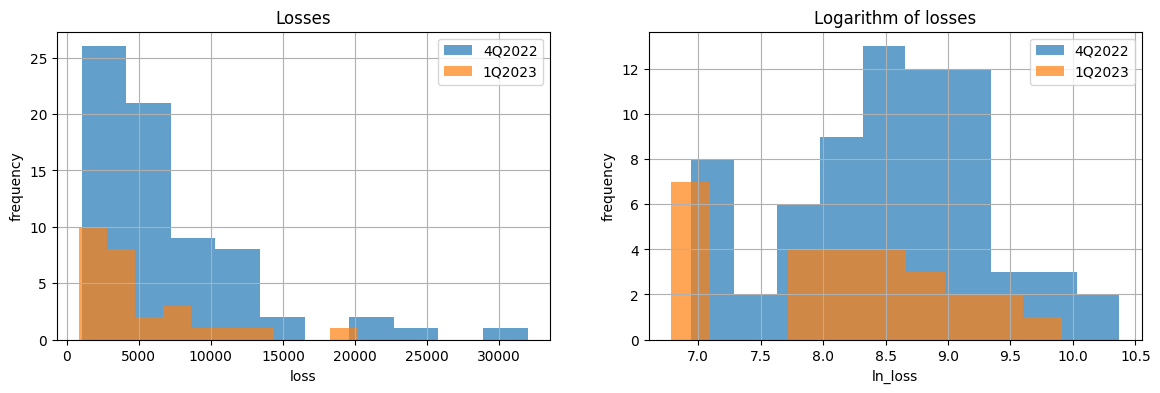

In [ ]:
plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.hist(control_sample['loss'], label = '4Q2022', bins=10, alpha=0.7)
plt.hist(test_sample['loss'], label = '1Q2023', bins=10, alpha=0.7)
plt.title('Losses')
plt.grid(True)
plt.legend()
plt.xlabel('loss')
plt.ylabel('frequency')

plt.subplot(1,2,2)
plt.hist(control_sample['ln_loss'], label = '4Q2022', bins=10, alpha=0.7)
plt.hist(test_sample['ln_loss'], label = '1Q2023', bins=10, alpha=0.7)
plt.title('Logarithm of losses')
plt.grid(True)
plt.legend()
plt.xlabel('ln_loss')
plt.ylabel('frequency')
plt.show()

There is no much difference between two periods. Let's run t-test with alpha = 0.05

#### t-test

The difference of means:

In [ ]:
control_sample['loss'].mean() - test_sample['loss'].mean()

1878.201058201058

In [ ]:
test_sample['loss'].mean() / control_sample['loss'].mean() - 1

-0.27368765159680686

In [ ]:
alpha = 0.05
results = st.ttest_ind(control_sample['ln_loss'], test_sample['ln_loss'], equal_var=True)
print('p-value:', round(results.pvalue,4))
print('t-statistic:', round(results.statistic,4))

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("We do not reject the null hypothesis")

p-value: 0.0359
t-statistic: 2.1287
We reject the null hypothesis


The difference of 27% is statistically significant (p<0.05)

### Percentage of policyholders who visited a health facility before and during the deductible period

The number of policyholders who visited the clinic in control group

In [ ]:
n_control = df_target_companies[df_target_companies['year_month'].isin(control_period)]['policy_id'].nunique()
n_control

32

The number of policyholders who visited the clinic in test group

In [ ]:
n_test = df_target_companies[df_target_companies['year_month'].isin(test_period)]['policy_id'].nunique()
n_test

15

The number of visitors dropped by:

In [ ]:
n_test/n_control - 1

-0.53125

#### z-test

The number of insured persons in the company we analysed:

In [ ]:
n = 60

In [ ]:
p_test = n_test/n
p_control = n_control/n
p_pooled = (n_test + n_control) / (n + n)
f'p_test: {round(p_test,2)}, p_control: {round(p_control,2)}, p_pooled: {round(p_pooled,2)}'

'p_test: 0.25, p_control: 0.53, p_pooled: 0.39'

In [ ]:
z_value = (p_control - p_test) / (p_pooled*(1-p_pooled)*(1/n+1/n))**(1/2)
z_value

3.1792829820262627

In [ ]:
p_value = (1-st.norm.cdf(abs(z_value)))*2
print('p-value: ', p_value)

p-value:  0.0014763987809316426


The difference of 53% is statistically significant (p<0.01)